# Finance clustering 

## Yahoo Finance

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from selenium import webdriver
import yfinance as yf

In [3]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [4]:
msft = yf.Ticker("MSFT")
msft.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-02,302.200012,303.359985,300.179993,301.149994,16285600,0,0
2021-09-03,300.989990,302.600006,300.260010,301.140015,14747900,0,0
2021-09-07,301.010010,301.089996,298.200012,300.179993,17180400,0,0
2021-09-08,299.779999,300.609985,297.470001,300.209991,15046800,0,0
2021-09-09,300.820007,302.140015,297.000000,297.250000,19927000,0,0
2021-09-10,298.420013,299.920013,295.380005,295.709991,19619400,0,0
2021-09-13,297.549988,298.540009,294.079987,296.989990,23652900,0,0
2021-09-14,299.559998,301.390015,298.100006,299.790009,21853400,0,0
2021-09-15,303.260010,305.320007,301.820007,304.820007,28356300,0,0


## In case you need all tickers

In [5]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [6]:
def load_with_selenium(url, chromedriver_path='/Users/dmitrys/Desktop/chromedriver'):
    driver = webdriver.Chrome(chromedriver_path)
    driver.get(url)
    driver.implicitly_wait(1)
    driver.find_element_by_css_selector('button.btn.primary').click()
    driver.implicitly_wait(1)
    df = pd.read_html(driver.find_element_by_tag_name("table").get_attribute('outerHTML'))[0]
    driver.close()
    return df

In [ ]:
n_group = 25

trending = load_with_selenium(f"https://finance.yahoo.com/trending-tickers?count={n_group}")
most_active = load_with_selenium(f"https://finance.yahoo.com/most-active?count={n_group}")
gainers = load_with_selenium(f"https://finance.yahoo.com/gainers?count={n_group}")
losers = load_with_selenium(f"https://finance.yahoo.com/losers?count={n_group}")

In [ ]:
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
print(interesting_tickers[:4])
print(len(interesting_tickers))

In [7]:
load = False

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1mo', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df = pd.DataFrame(full_ticker_data)
    full_ticker_df.to_csv("full_ticker_df_month_07_2021.csv")

else: 
    full_ticker_df = pd.read_csv("full_ticker_df_month_07_2021.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [9]:
full_ticker_df.shape

(90, 28)

In [8]:
full_ticker_df.head()

,shortName,sector,industry,country,market,2021-06-28 00:00:00,2021-06-29 00:00:00,2021-06-30 00:00:00,2021-07-01 00:00:00,2021-07-02 00:00:00,...,2021-07-16 00:00:00,2021-07-19 00:00:00,2021-07-20 00:00:00,2021-07-21 00:00:00,2021-07-22 00:00:00,2021-07-23 00:00:00,2021-07-26 00:00:00,2021-07-27 00:00:00,2021-07-28 00:00:00,2021-07-05 00:00:00
0,UP Fintech Holding Limited,Financial Services,Capital Markets,China,us_market,28.320000,29.280001,28.980000,26.170000,25.570000,...,17.920000,17.770000,18.000000,19.670000,18.070000,16.879999,16.680000,14.530000,16.840000,NaN
1,Li Auto Inc.,Consumer Cyclical,Auto Manufacturers,China,us_market,33.709999,34.250000,34.939999,34.689999,32.669998,...,30.320000,30.540001,30.730000,33.410000,32.930000,30.280001,30.770000,26.480000,29.959999,NaN
2,"Shineco, Inc.",Healthcare,Drug Manufacturers—Specialty & Generic,China,us_market,6.870000,6.770000,6.320000,6.480000,6.510000,...,4.450000,4.370000,4.610000,4.760000,4.620000,4.460000,4.430000,4.310000,4.456300,NaN
3,McDonald's Corporation,Consumer Cyclical,Restaurants,United States,us_market,231.089996,230.369995,230.990005,232.270004,233.630005,...,234.750000,229.259995,234.270004,235.929993,238.669998,242.960007,243.979996,246.350006,240.654999,NaN
4,Shopify Inc.,Technology,Software—Application,Canada,us_market,1494.989990,1482.989990,1460.979980,1458.000000,1464.750000,...,1442.630005,1472.010010,1524.780029,1569.359985,1594.089966,1643.319946,1582.280029,1555.099976,1539.606934,NaN


In [10]:
full_ticker_df.isnull().sum(axis=1)

0     1
1     1
2     1
3     1
4     1
     ..
85    1
86    1
87    6
88    1
89    1
Length: 90, dtype: int64

In [11]:
full_ticker_df = full_ticker_df.iloc[:, :-1]

In [12]:
prices = full_ticker_df.iloc[:, 5:].T

In [13]:
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')

In [14]:
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

In [15]:
full_ticker_df.dropna(inplace=True)

In [16]:
full_ticker_df.shape

(88, 27)

In [17]:
full_ticker_df

,shortName,sector,industry,country,market,2021-06-28 00:00:00,2021-06-29 00:00:00,2021-06-30 00:00:00,2021-07-01 00:00:00,2021-07-02 00:00:00,...,2021-07-15 00:00:00,2021-07-16 00:00:00,2021-07-19 00:00:00,2021-07-20 00:00:00,2021-07-21 00:00:00,2021-07-22 00:00:00,2021-07-23 00:00:00,2021-07-26 00:00:00,2021-07-27 00:00:00,2021-07-28 00:00:00
0,UP Fintech Holding Limited,Financial Services,Capital Markets,China,us_market,28.320000,29.280001,28.980000,26.170000,25.570000,...,18.570000,17.920000,17.770000,18.000000,19.670000,18.070000,16.879999,16.680000,14.530000,16.840000
1,Li Auto Inc.,Consumer Cyclical,Auto Manufacturers,China,us_market,33.709999,34.250000,34.939999,34.689999,32.669998,...,30.980000,30.320000,30.540001,30.730000,33.410000,32.930000,30.280001,30.770000,26.480000,29.959999
2,"Shineco, Inc.",Healthcare,Drug Manufacturers—Specialty & Generic,China,us_market,6.870000,6.770000,6.320000,6.480000,6.510000,...,4.850000,4.450000,4.370000,4.610000,4.760000,4.620000,4.460000,4.430000,4.310000,4.456300
3,McDonald's Corporation,Consumer Cyclical,Restaurants,United States,us_market,231.089996,230.369995,230.990005,232.270004,233.630005,...,236.880005,234.750000,229.259995,234.270004,235.929993,238.669998,242.960007,243.979996,246.350006,240.654999
4,Shopify Inc.,Technology,Software—Application,Canada,us_market,1494.989990,1482.989990,1460.979980,1458.000000,1464.750000,...,1441.500000,1442.630005,1472.010010,1524.780029,1569.359985,1594.089966,1643.319946,1582.280029,1555.099976,1539.606934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,"Tilray, Inc. - Class 2",Healthcare,Drug Manufacturers—Specialty & Generic,Canada,us_market,18.629999,17.860001,18.080000,17.840000,17.230000,...,14.400000,13.910000,13.600000,14.160000,14.600000,13.880000,13.590000,13.700000,12.730000,16.049999
85,Bilibili Inc.,Communication Services,Electronic Gaming & Multimedia,China,us_market,126.849998,125.559998,121.839996,121.110001,119.580002,...,110.120003,109.010002,108.480003,111.919998,115.580002,108.660004,95.209999,87.459999,82.730003,95.150002
86,Carnival Corporation,Consumer Cyclical,Travel Services,United States,us_market,26.150000,25.780001,26.360001,26.360001,26.059999,...,21.950001,20.920000,19.719999,21.190001,23.190001,22.709999,21.959999,23.160000,22.799999,22.780001
88,The Cheesecake Factory Incorpor,Consumer Cyclical,Restaurants,United States,us_market,53.430000,52.450001,54.180000,53.639999,53.330002,...,51.160000,49.849998,46.959999,50.119999,51.790001,51.950001,51.790001,54.520000,55.009998,48.730099


## Scaling everything

In [18]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T
plt.plot(tickers_scaled.T);

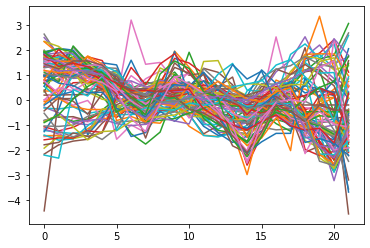

In [19]:
plt.plot(tickers_scaled.T);

# Basic KMeans

  0%|          | 0/8 [00:00<?, ?it/s]

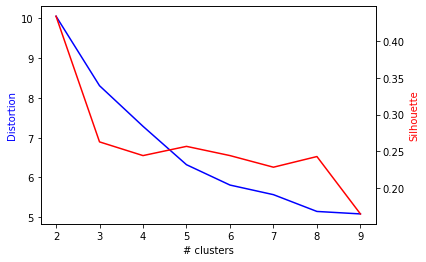

In [20]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [21]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=5, n_jobs=6)

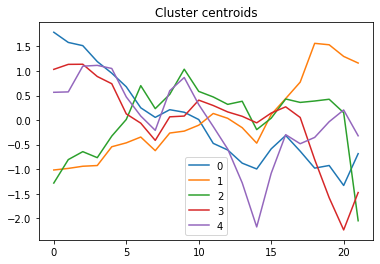

In [22]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [23]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Healthcare                   8
        Consumer Cyclical            7
        Financial Services           5
        Technology                   5
        Communication Services       3
        Consumer Defensive           1
1       Consumer Cyclical            5
        Technology                   4
        Communication Services       3
        Healthcare                   2
        Industrials                  1
        Real Estate                  1
2       Healthcare                   2
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
        Financial Services           1
        Industrials                  1
        Technology                   1
3       Consumer Cyclical            6
        Healthcare                   4
        Technology                   4
        Communication Services       2
        Industrials                  2
        Basic Materials              1
        Consumer Defensive           1
        Real Estate                  1
4       Consumer Cyclical            5
        Communication Services       2
        Industrials                  2
        Technology                   2
        Basic Materials              1
        Energy                       1
        Financial Services           1

In [24]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


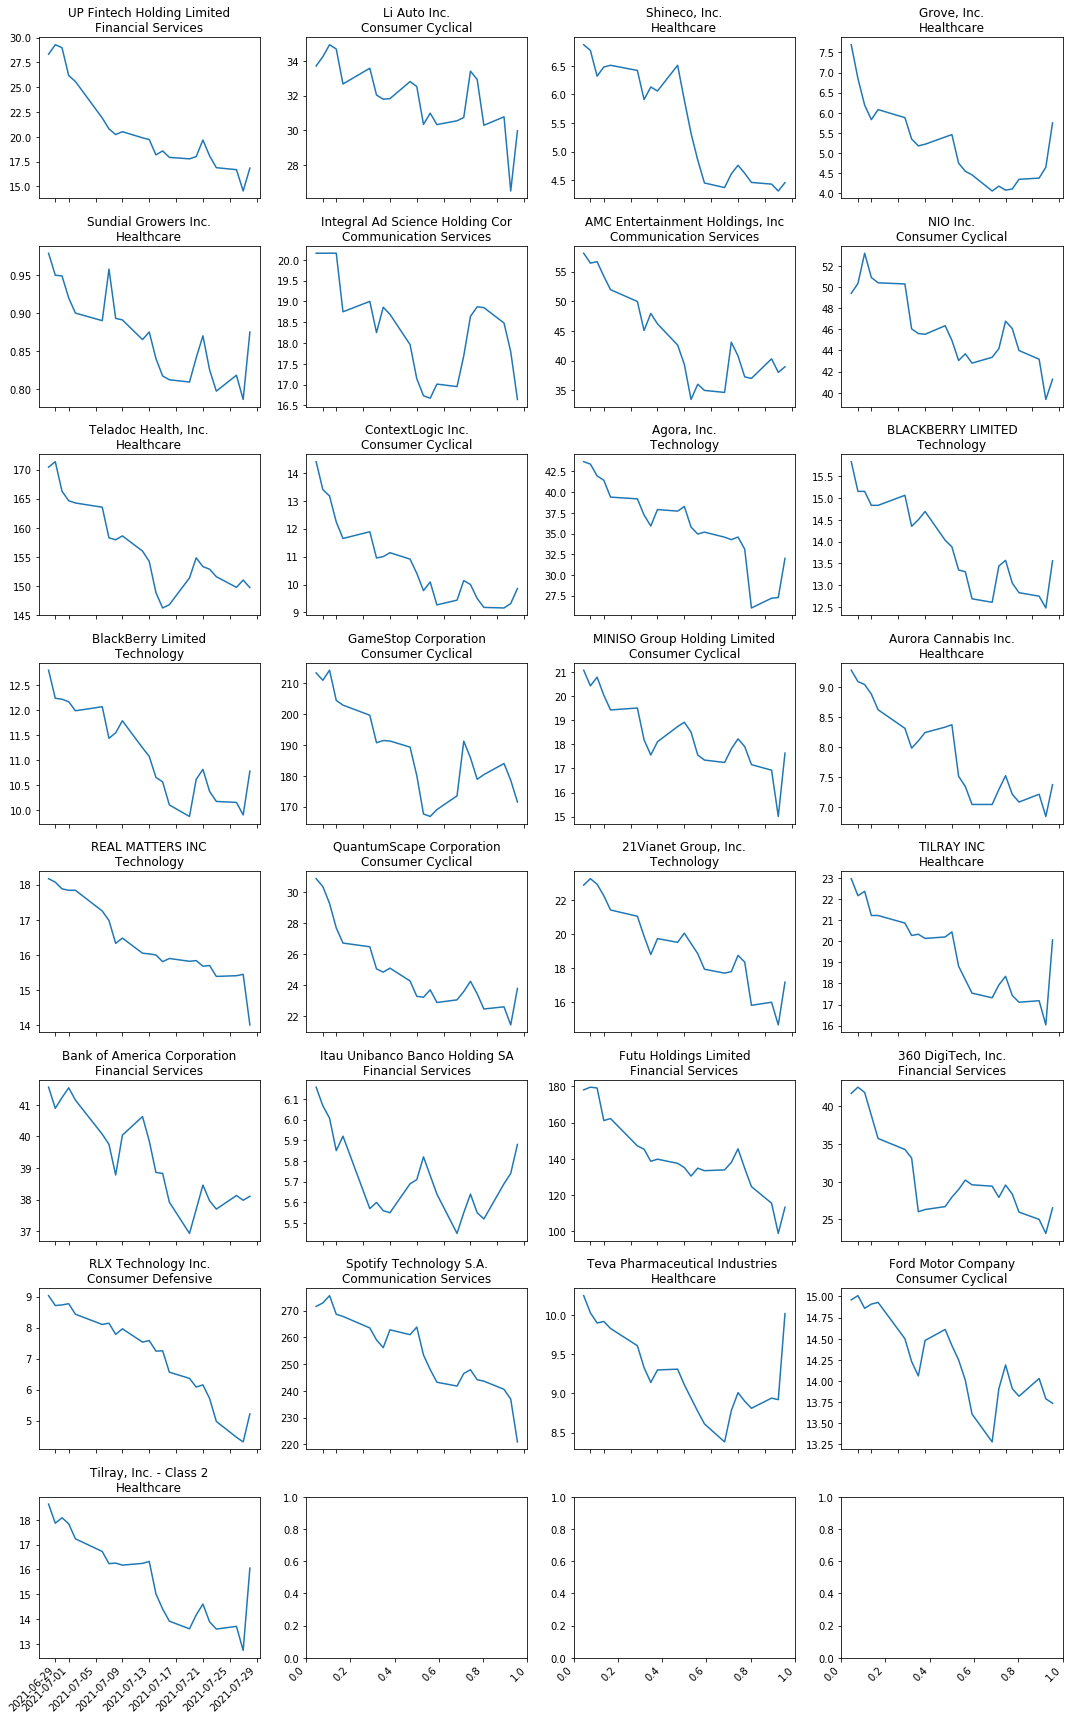

                          Cluster number: 1


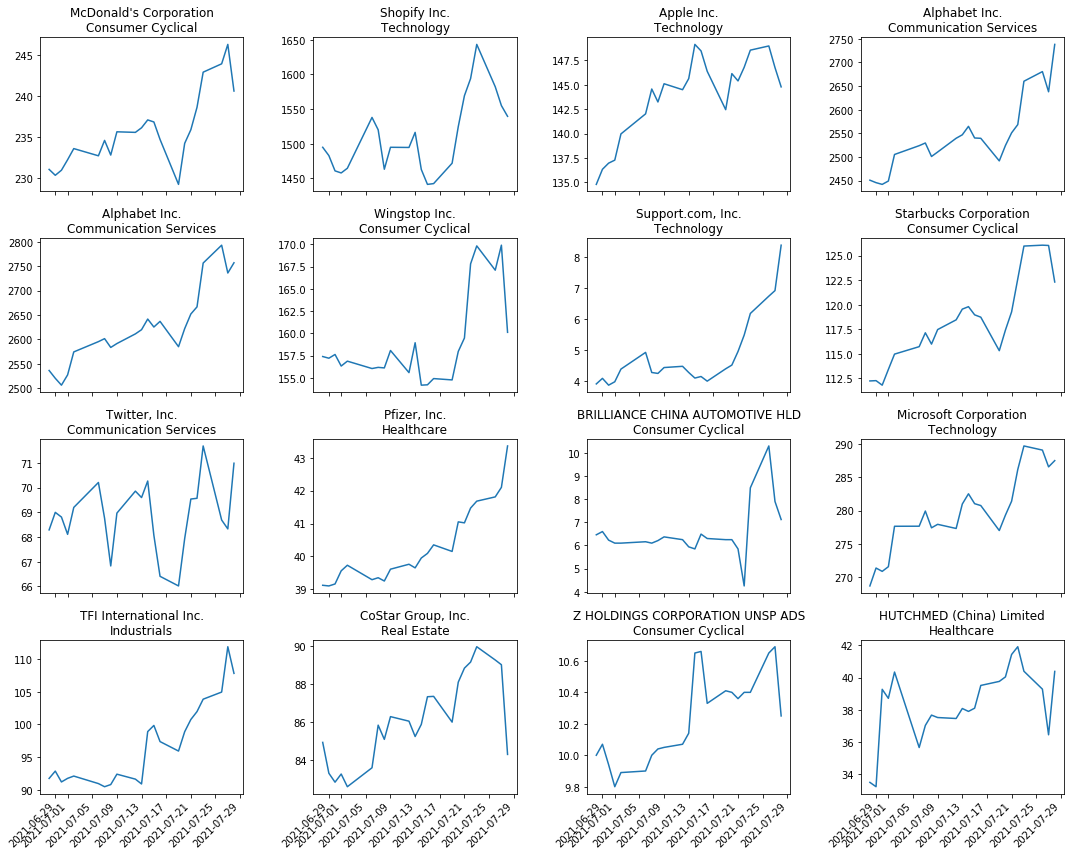

                          Cluster number: 2


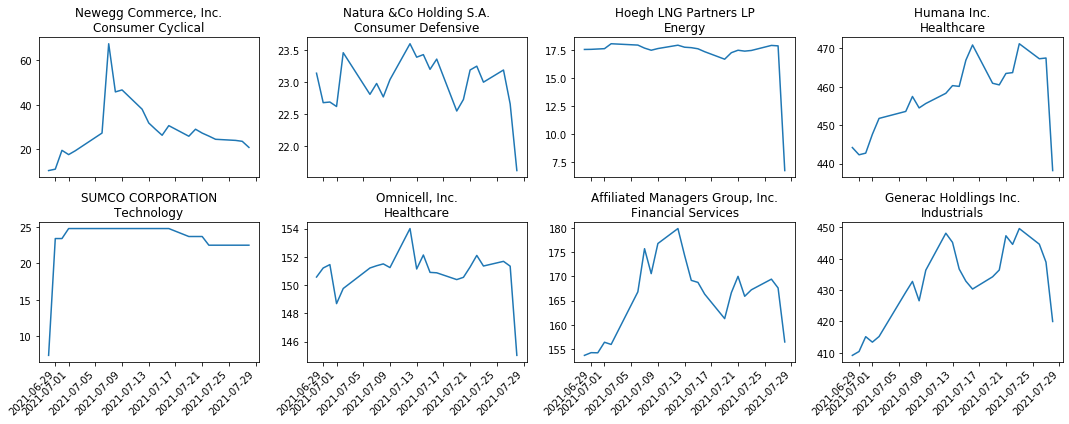

                          Cluster number: 3


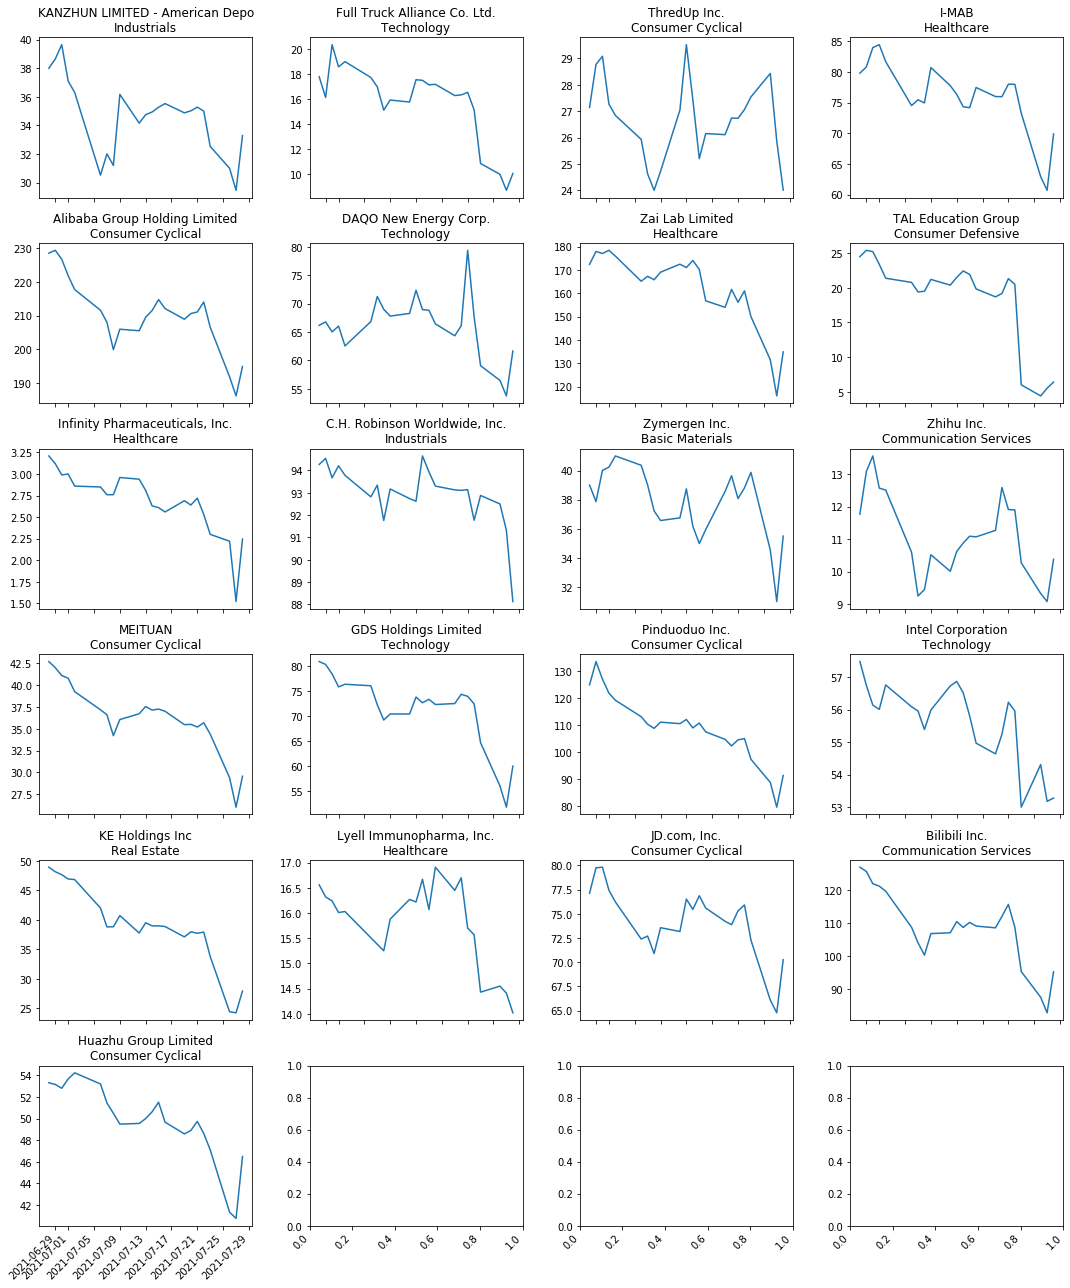

                          Cluster number: 4


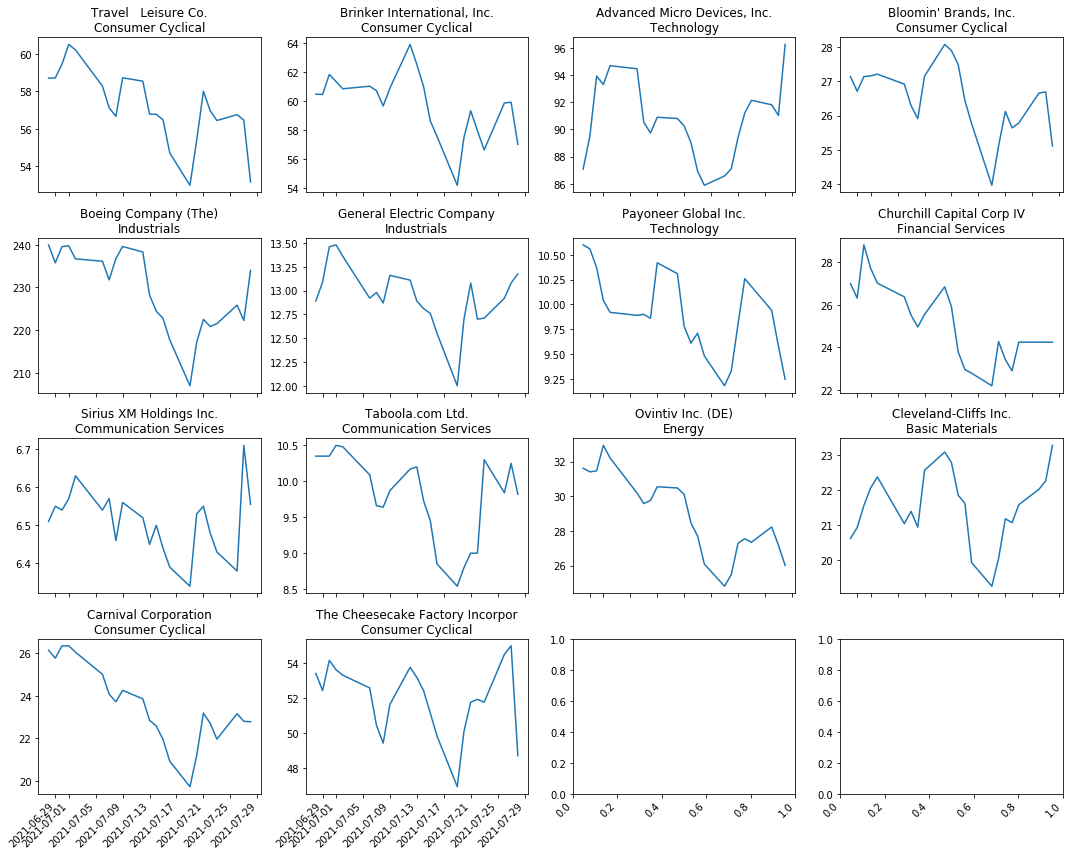

In [25]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# DTW

  0%|          | 0/8 [00:00<?, ?it/s]

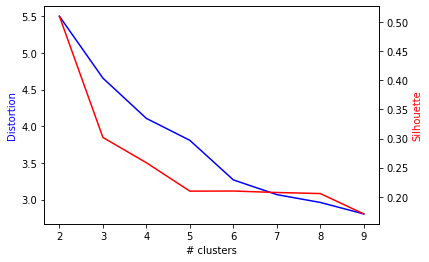

In [26]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

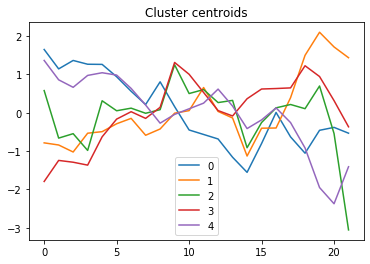

In [31]:
n_clusters = 5
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [29]:
full_ticker_df['cluster'].value_counts()

0    29
3    21
1    16
4    14
2     8
Name: cluster, dtype: int64

In [32]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Consumer Cyclical            8
        Healthcare                   8
        Financial Services           5
        Communication Services       4
        Industrials                  3
        Technology                   3
        Energy                       1
1       Communication Services       4
        Consumer Cyclical            4
        Technology                   4
        Basic Materials              1
        Healthcare                   1
        Industrials                  1
2       Consumer Cyclical            2
        Consumer Defensive           1
        Energy                       1
        Healthcare                   1
        Industrials                  1
3       Consumer Cyclical            2
        Healthcare                   2
        Technology                   2
        Financial Services           1
        Industrials                  1
        Real Estate                  1
4       Consumer Cyclical            8
        Technology                   7
        Healthcare                   4
        Communication Services       2
        Consumer Defensive           2
        Basic Materials              1
        Financial Services           1
        Real Estate                  1

                          Cluster number: 0


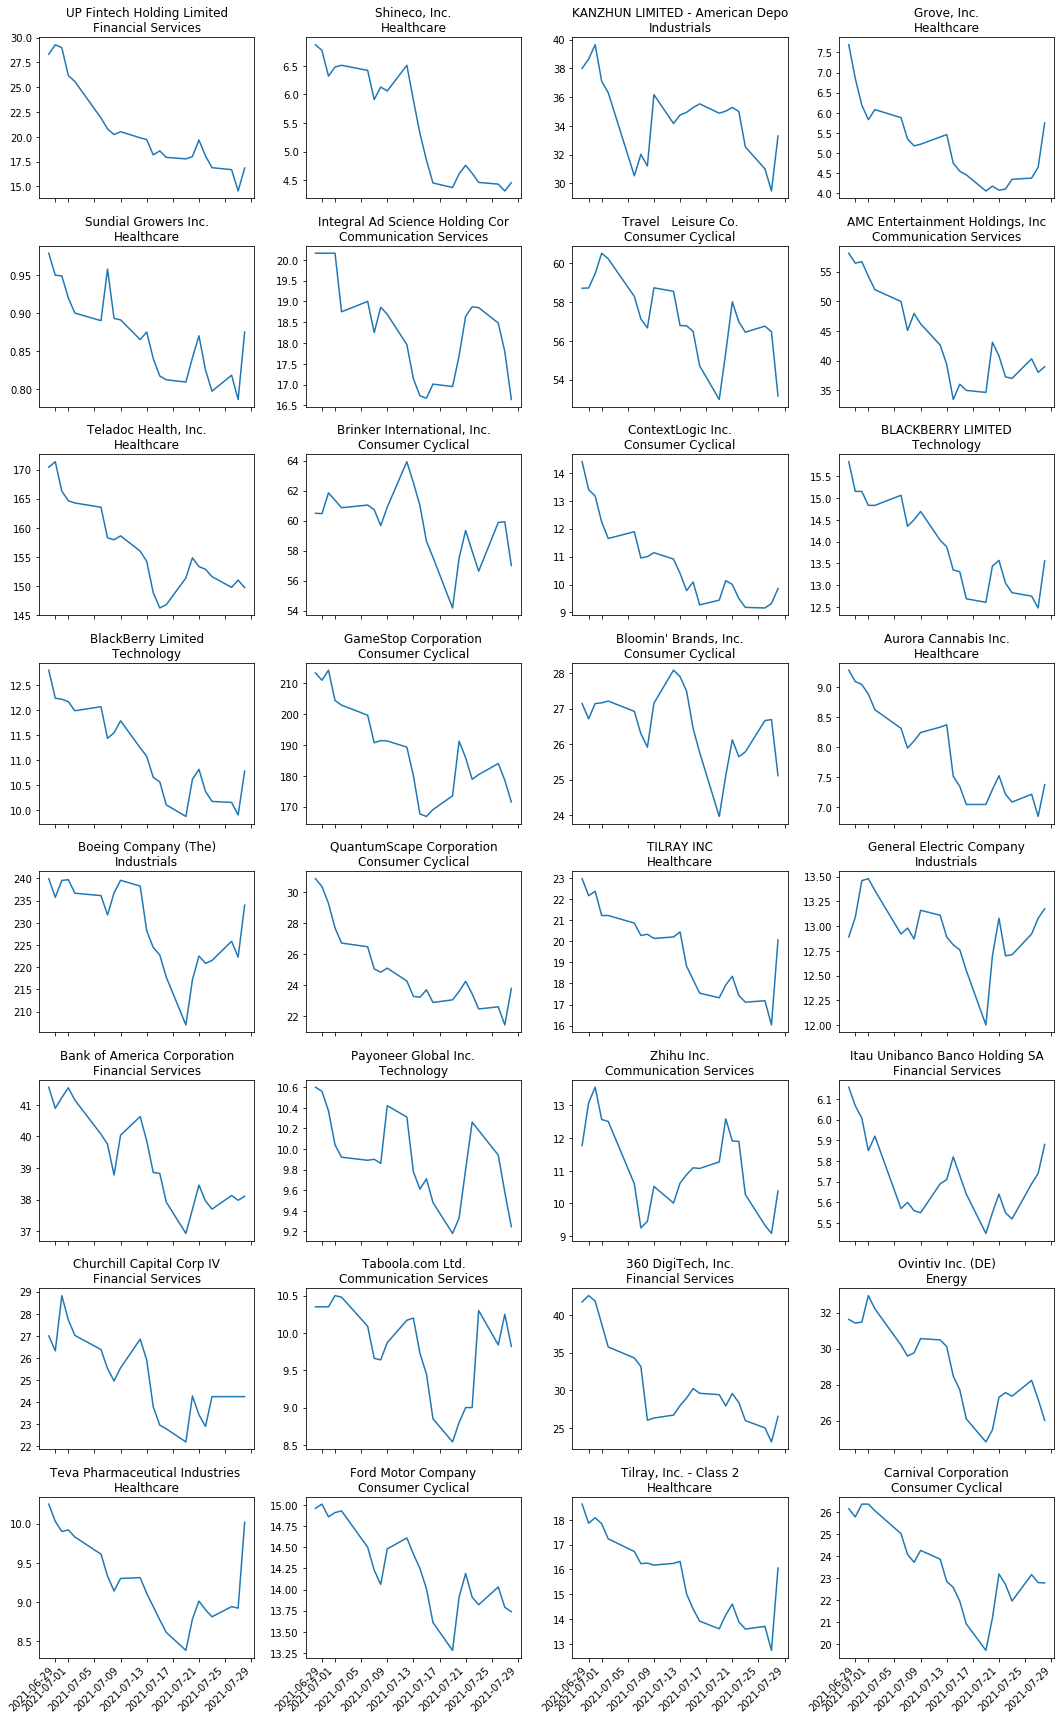

                          Cluster number: 1


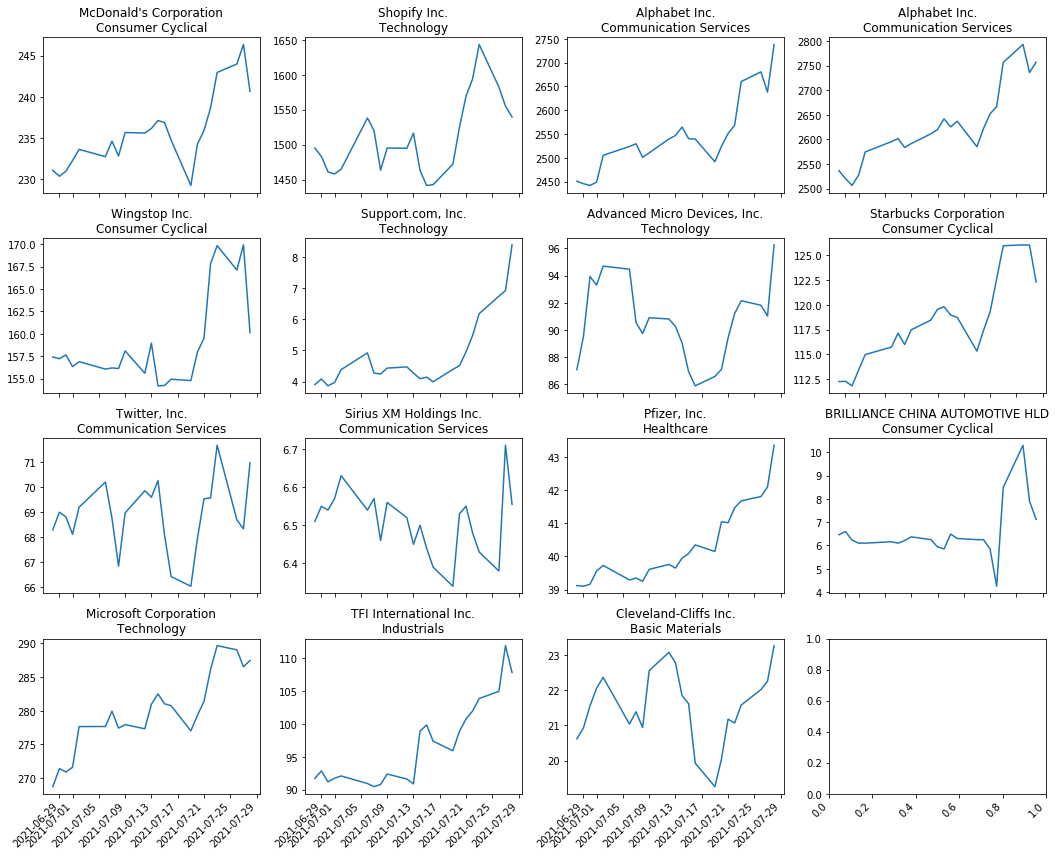

                          Cluster number: 2


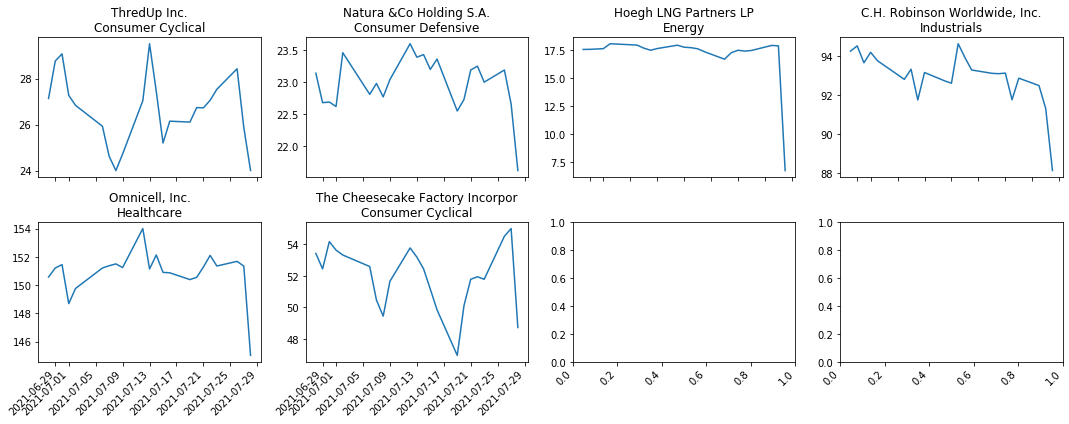

                          Cluster number: 3


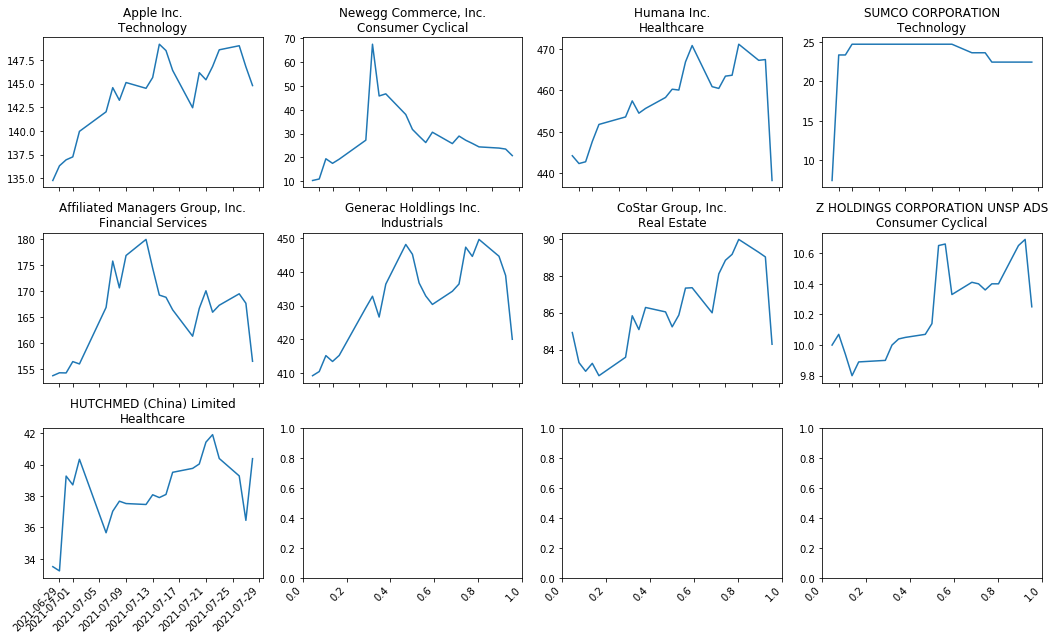

                          Cluster number: 4


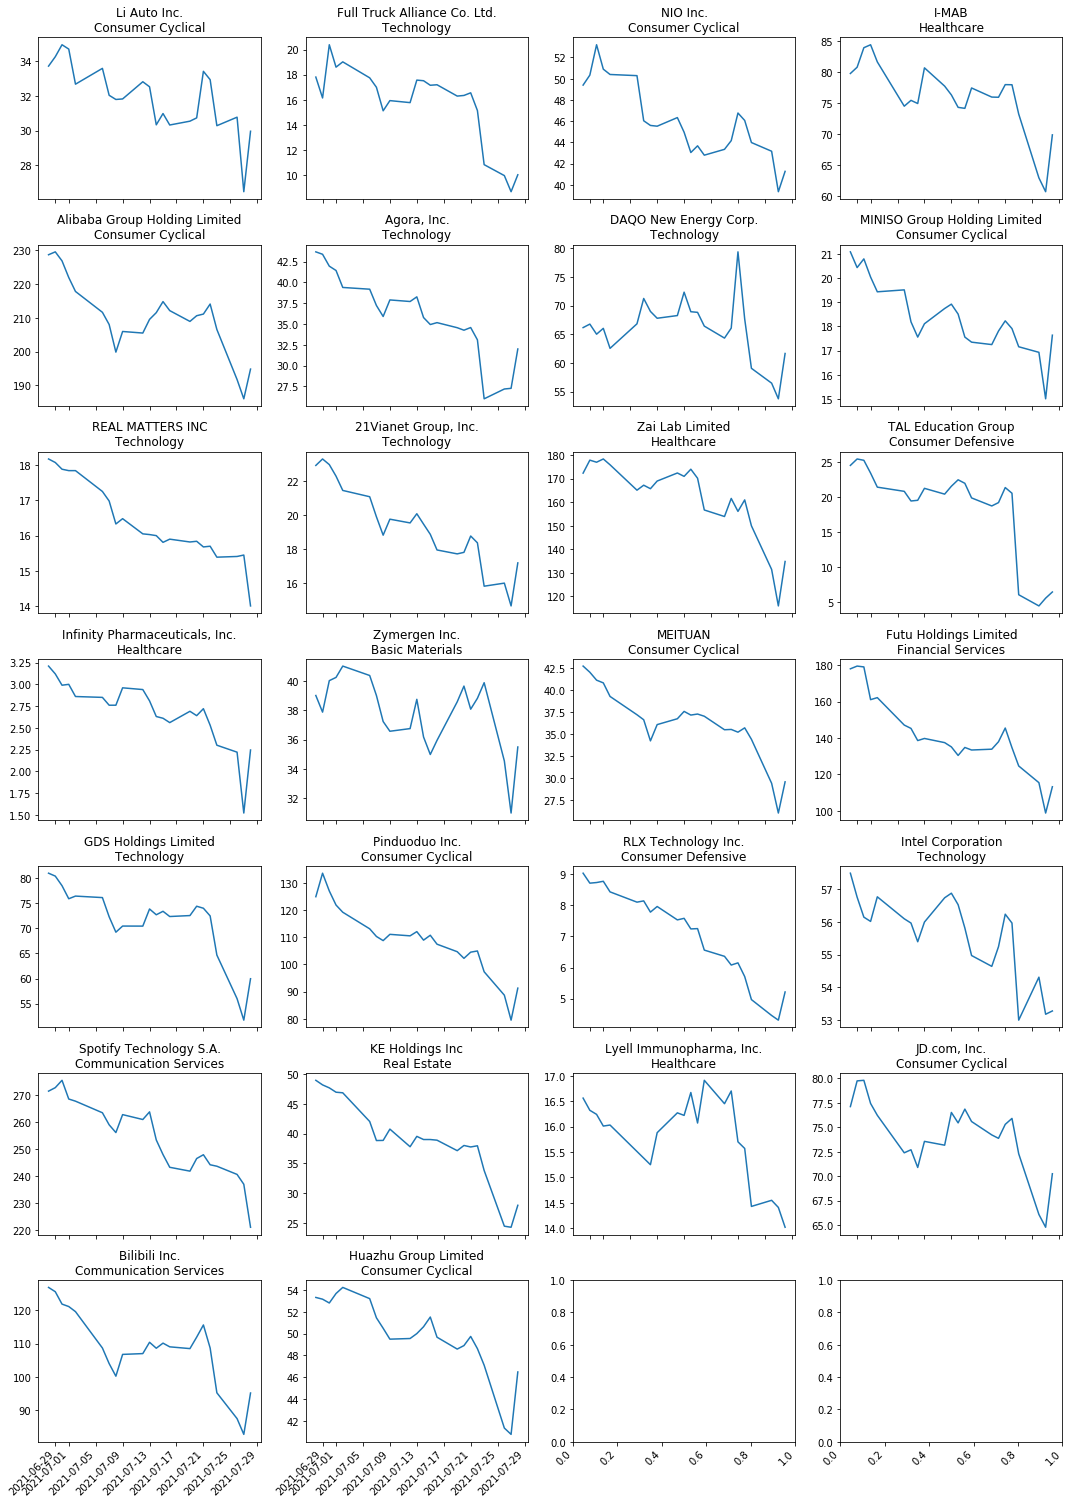

In [33]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])